This is a program which is in testing phase. We will use a linear regression ML model to give an SOC number for the flights.

In [1]:
# Import the querying module
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [2]:
# ONE-HOT ENCODE
# https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/
def one_hot(df, col, pre):
  encoded = pd.get_dummies(df[col], prefix=pre)
  for column in encoded:
    encoded = encoded.rename(columns={column: col + "_" + column})
  encoded['unique_data_identifier'] = df['unique_data_identifier']
  return encoded

In [3]:
all_data = pd.read_csv("ml_model_outputs/all_data.csv")

In [4]:
encoded_data  = one_hot(all_data, "activity", "is")
X = pd.merge(all_data, encoded_data, on=["unique_data_identifier"])
Y = X["soc_delta"].to_numpy()
X.drop(columns=["soc_delta", "activity",  "id", "unique_data_identifier"], inplace=True)

In [5]:
# Split the data into train and test sets
train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.3, random_state=43)

In [6]:
print(f"Length train_x = {len(train_X)} \n Length train_y = {len(train_y)}")

Length train_x = 1199 
 Length train_y = 1199


In [7]:
print(f"Length test_x = {len(test_X)} \n Length test_y = {len(test_y)}")

Length test_x = 514 
 Length test_y = 514


Machine Learning Model Implementation

In [8]:
from sklearn.linear_model import Ridge

# Set model
ridge_model = Ridge(alpha=0.9)  # You can adjust the alpha parameter for regularization strength

# Fit model
ridge_model.fit(train_X, train_y)

Ridge(alpha=0.9)

In [9]:
# Make predictions using the testing set
y_pred = ridge_model.predict(test_X)

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_error

# Mean Squared Error (MSE)
mse = mean_squared_error(test_y, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Coefficient of Determination (R-squared)
r_squared = r2_score(test_y, y_pred)
print(f'Coefficient of Determination (R-squared): {r_squared}')

# K-fold Cross-Validation for R-squared
cross_val_r_squared = cross_val_score(ridge_model, train_X, train_y, cv=5, scoring='r2')
print(f'Cross-validated R-squared: {np.mean(cross_val_r_squared)}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(test_y, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(test_y, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

from sklearn.model_selection import cross_val_score, KFold

# Define the number of folds (k)
num_folds = 12  # You can adjust this based on your preference

# Create a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation for R-squared
cross_val_r_squared = cross_val_score(ridge_model, train_X, train_y, cv=kf, scoring='r2')

# Display the results
print(f'K-fold Cross-validated R-squared: {np.mean(cross_val_r_squared)}')

Mean Squared Error (MSE): 4.1551310479110475
Coefficient of Determination (R-squared): 0.3696875824349066
Cross-validated R-squared: 0.6785343519536767
Mean Absolute Error (MAE): 1.153943275460013
Root Mean Squared Error (RMSE): 2.0384138558965517
K-fold Cross-validated R-squared: 0.6262362798426531


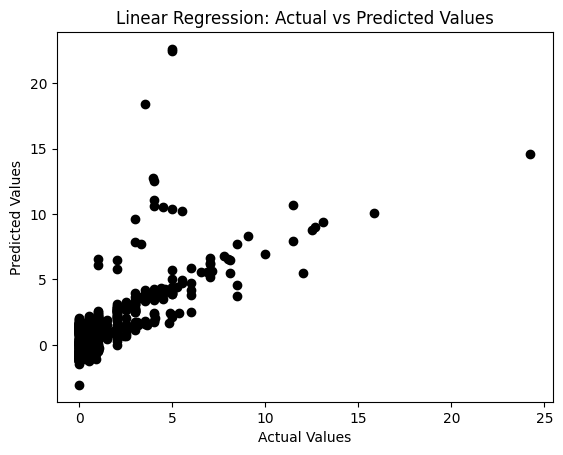

In [11]:
import matplotlib.pyplot as plt

# Plot outputs
plt.scatter(test_y, y_pred, color="black")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression: Actual vs Predicted Values")

plt.show()

In [12]:
coeff = pd.DataFrame(list(zip(ridge_model.feature_names_in_, ridge_model.coef_)), columns = ['Feature', 'Weight'])
coeff.sort_values('Weight')

,Feature,Weight
16,activity_is_pre-flight,-11.254641
13,activity_is_post-flight,-3.447113
7,wind_speed,-0.030888
1,soh,-0.016243
5,temperature,-0.006902
2,average_altitude,0.005207
3,ground_speed,0.006843
4,average_power,0.010204
6,visibility,0.029772
20,activity_is_takeoff,0.294068


In [13]:
import joblib

model_filename = 'ML_model_outputs/prescription_ridgereg_model.joblib'
joblib.dump(ridge_model, model_filename)

print(f"Model saved to {model_filename}")

Model saved to ML_model_outputs/prescription_ridgereg_model.joblib
